In [7]:
import sys, os
from constants import *
import torch, esm, scipy
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from tqdm import tqdm
from Bio.PDB import PDBParser, PPBuilder
import matplotlib.patches as patches

np.random.seed(1024)
import pickle

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
model, alphabet = esm.pretrained.esm2_t33_650M_UR50D()
batch_converter = alphabet.get_batch_converter()
model.to(device).eval()

AAs = "ACDEFGHIKLMNPQRSTVWY"

# using ESM dictionary
aa2indx = {tok:idx for idx, tok in enumerate(alphabet.all_toks) if tok in AAs}
id2aa = {i:aa for i,aa in enumerate(list(aa2indx.keys()))}
aa2id_np = {aa:i for i,aa in id2aa.items()}

# Helper functions

In [3]:
def get_ESM2_probs_VP1(motif, pep):
    assert pep[2:-2] == motif
    start = seq_wt.index(VR)
    end = seq_wt.index(VR)+len(VR)
    assert seq_wt[start:end] == VR
    
    seq_mu = seq_wt
    seq_mu = seq_mu[:start] + pep + seq_mu[end:]
    
    data = [(f"seq", seq_mu),]
    batch_labels, batch_strs, batch_tokens = batch_converter(data)
    batch_lens = (batch_tokens != alphabet.padding_idx).sum(1)
    with torch.no_grad():
        results = model(batch_tokens.to(device))
    
    logits = results['logits'][:,1:-1,list(aa2indx.values())].cpu()[0]
    probs = scipy.special.softmax(logits, axis=-1)
    return probs

def get_ESM2_probs(motif, pep):
    assert pep[2:-2] == motif
    start = seq_wt.index(VR)
    end = seq_wt.index(VR)+len(VR)
    assert seq_wt[start:end] == VR
    
    seq_mu = seq_wt
    seq_mu = seq_mu[:start] + pep + seq_mu[end:]
    
    data = [(f"seq", seq_mu),]
    batch_labels, batch_strs, batch_tokens = batch_converter(data)
    batch_lens = (batch_tokens != alphabet.padding_idx).sum(1)
    with torch.no_grad():
        results = model(batch_tokens.to(device))
    
    logits = results['logits'][:,1:-1,list(aa2indx.values())].cpu()[0]
    probs = scipy.special.softmax(logits, axis=-1)
    ps = probs[start:start+len(pep)]
    ps = [float(ps[i, aa2id_np[pep[i]]]) for i in range(len(pep))]
    p_linker = np.average([p for i,p in enumerate(ps) if i in [0,1,10,11]])
    p_VR = np.average(ps)
    return float(p_linker), float(p_VR)

def get_sequence_from_PDB(path_pdb, chain_id):
    parser = PDBParser(QUIET=True)
    structure = parser.get_structure("struct", path_pdb)
    ppb = PPBuilder()
    for model in structure:
        for chain in model:
            if chain.id==chain_id:
                seq = ""
                for pp in ppb.build_peptides(chain):
                    seq += str(pp.get_sequence())
    return seq

def plot_histogram(
    x1, x2, label1, label2,
    path_save_fig,
    figsize=(4,3), dpi=300,
    xlabel=None,
    plot=True,
):
    plt.figure(figsize=figsize, dpi=dpi)
    sns.histplot(x1, label=label1, bins=20, stat="density", kde=True,
                 color="red", alpha=0.2, edgecolor="white")
    
    sns.histplot(x2, label=label2, bins=20, stat="density", kde=True,
                 color="gray", alpha=0.2, edgecolor="white")
    
    plt.xlabel(xlabel, fontsize=16)
    plt.ylabel("Density", fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    # plt.legend(fontsize=10, frameon=False)
    sns.despine()
    
    plt.tight_layout()
    plt.gca().patch.set_alpha(0)
    plt.gcf().patch.set_alpha(0)
    plt.savefig(path_save_fig, transparent=True)
    if plot:
        plt.show()

# Score the Rosetta outputs

In [4]:
for p, motif in motifs.items():
    df = pd.read_csv(f'{dir_out_rosetta}/AAV9_{p}/score.sc', delimiter='\s+', skiprows=1,)
    df = df.sort_values('total_score', ascending=True).reset_index(drop=True)
    
    scores = []
    for f in tqdm(df.description.tolist()):
        path_pdb = f'{dir_out_rosetta}/AAV9_{p}/output_design/{f[:-5]}.pdb'
        s = get_sequence_from_PDB(path_pdb, "A")
        pep = s[233:245] # modified VR4 part only
        p_linker, p_VR = get_ESM2_probs(motif, pep)
        scores.append((pep, p_linker, p_VR))
    
    pep, p_linker, p_VR = zip(*scores)
    df['VR4_seq'] = pep
    df['ESM2_mean_linker'] = p_linker
    df['ESM2_mean_VR4'] = p_VR
    df.to_csv(f'../ESM2_MPNN_score/score_rosetta_ESM2_MPNN-BBonly_{p}.csv', index=False)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 600/600 [03:48<00:00,  2.63it/s]


# Generate and score 500 random sequences

In [5]:
scores_random = {}
for p, motif in motifs.items():
    scores_random[p] = {"seq": [], "p_linker":[], "p_VR":[]}
    linkers_random = np.random.choice(list(AAs), size=(500, 4), replace=True).tolist()
    for linker in tqdm(linkers_random):
        pep = linker[0]+linker[1]+ motif + linker[2]+linker[3]
        p_linker, p_VR = get_ESM2_probs(motif, pep)
        scores_random[p]["seq"].append(pep)
        scores_random[p]["p_linker"].append(p_linker)
        scores_random[p]["p_VR"].append(p_VR)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [01:29<00:00,  5.60it/s]


Motif 4um9:
   KS test - Linker Only: 3.409e-55
Motif 5ffo:
   KS test - Linker Only: 8.256e-79
Motif 5nem:
   KS test - Linker Only: 1.863e-69


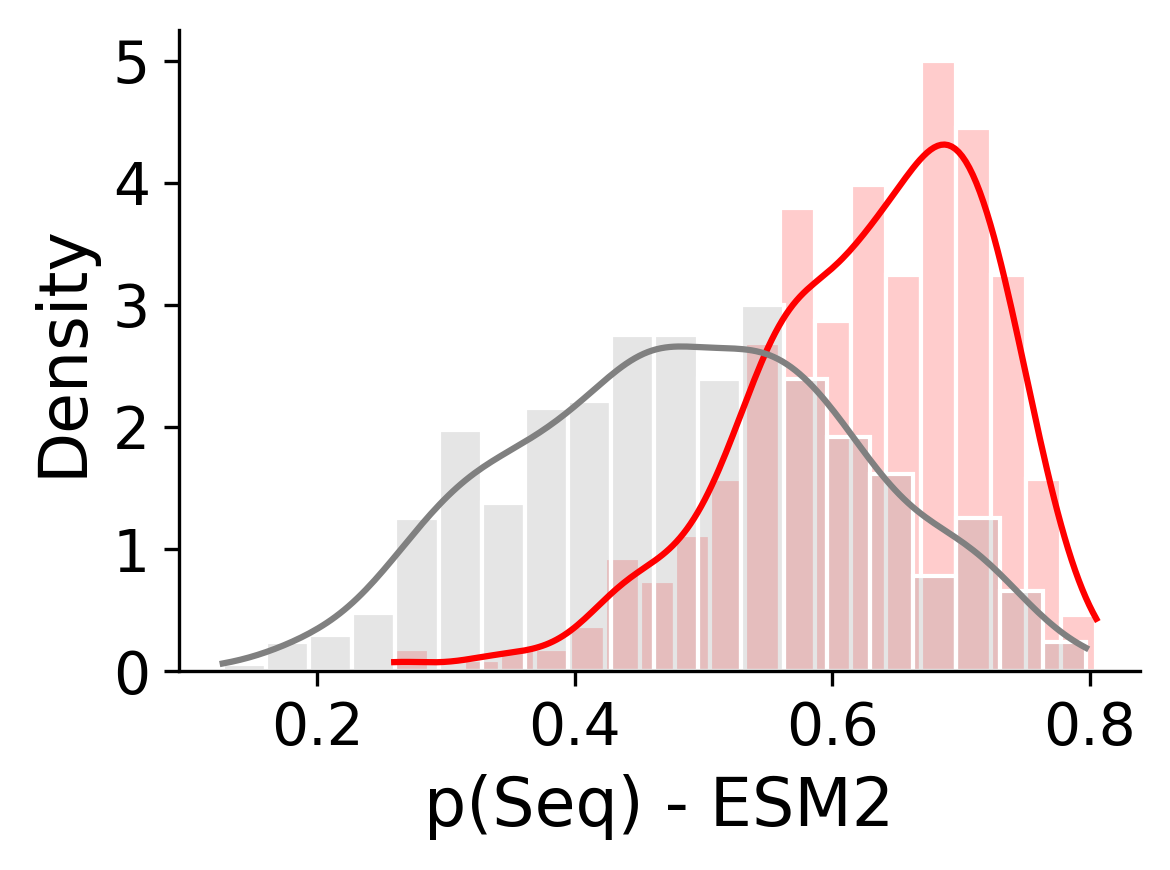

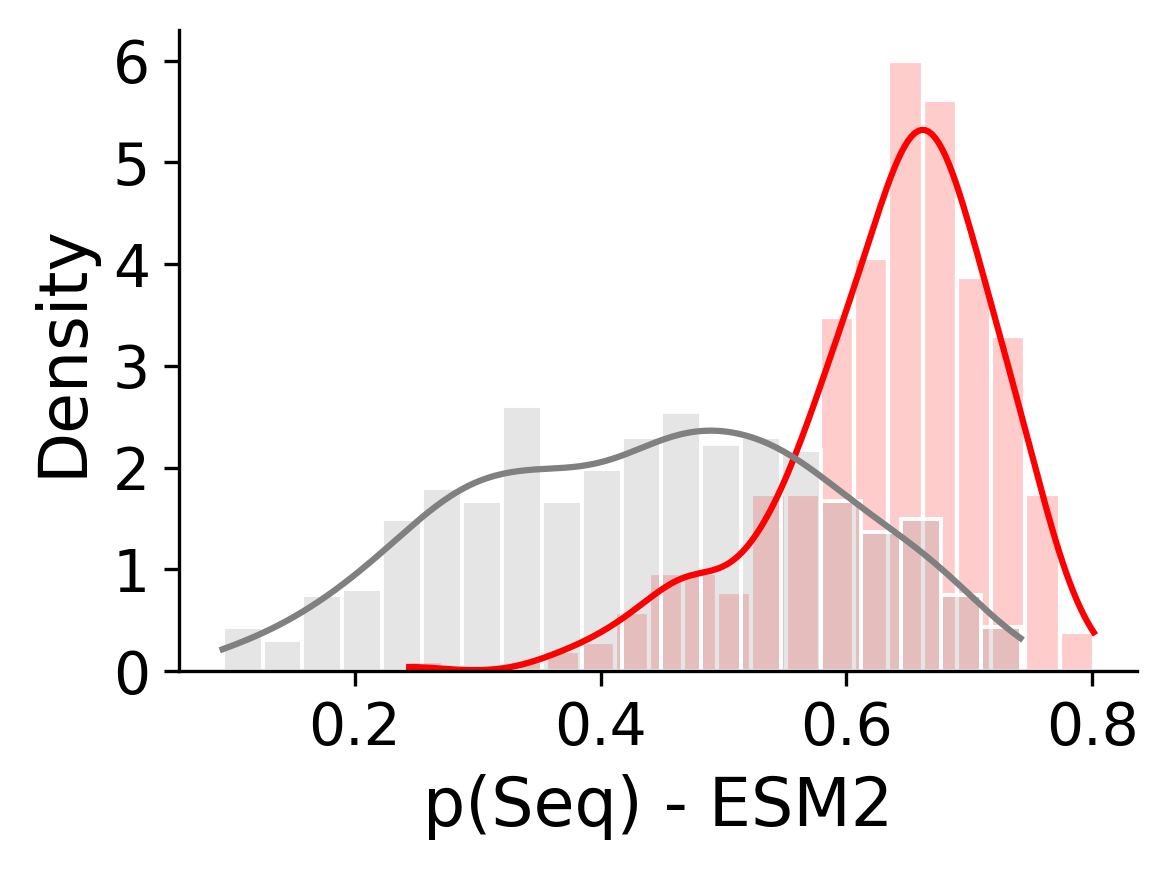

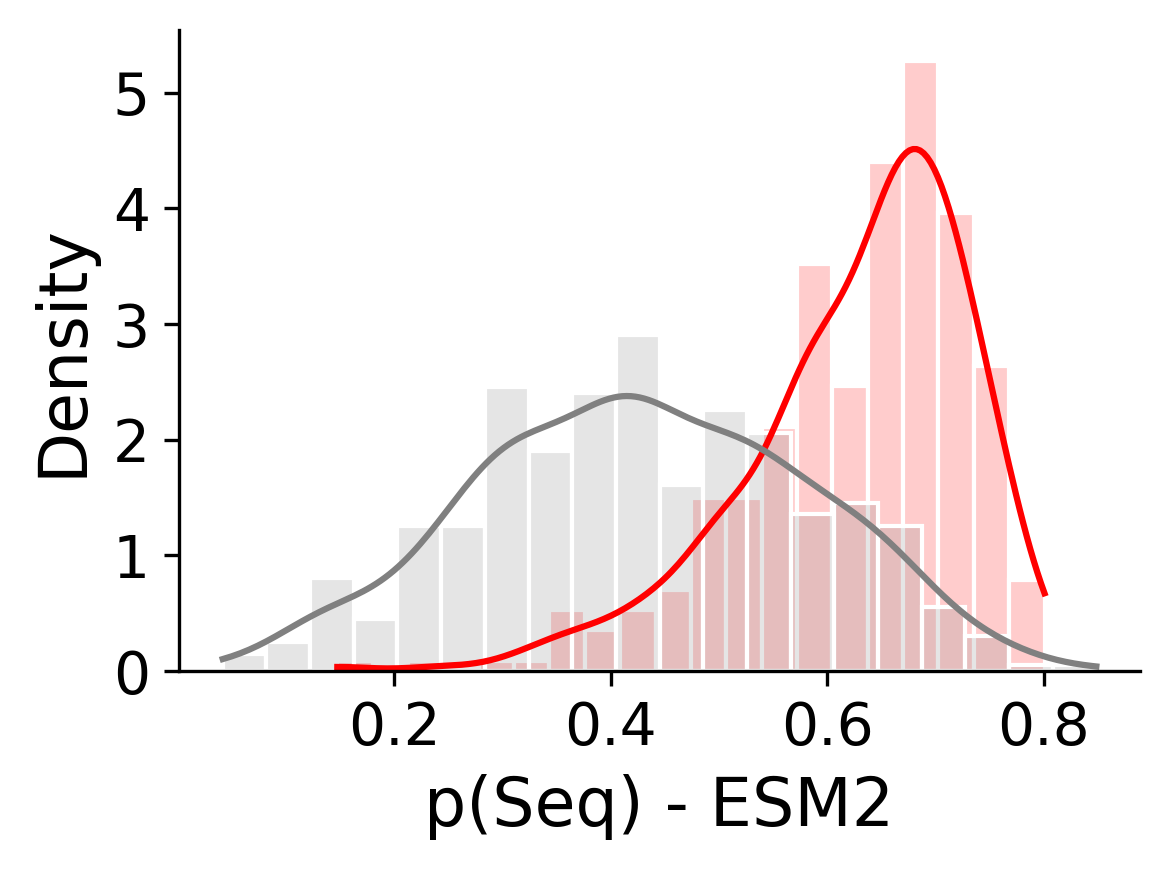

In [8]:
for p, motif in motifs.items():
    print(f"Motif {p}:")
    df_rosetta = pd.read_csv(f'../ESM2_MPNN_score/score_rosetta_ESM2_MPNN-BBonly_{p}.csv')
    score_random = scores_random[p].copy()
    peps, ps_linker, ps_VR = list(score_random.values())
    for pep, p_linker, p_VR in zip(peps, ps_linker, ps_VR):
        if pep in df_rosetta.VR4_seq.tolist():
            peps.remove(pep)
            ps_linker.remove(p_linker)
            ps_VR.remove(p_VR)
    
    df_rosetta = df_rosetta.loc[df_rosetta.groupby("VR4_seq")["total_score"].idxmin()]
    plot_histogram(
        df_rosetta.ESM2_mean_linker, ps_linker, 
        label1=None, label2=None, 
        path_save_fig=f"./figures/rosetta_vs_random_{p}_linkeronly.svg",
        figsize=(4,3), dpi=300,
        xlabel="p(Seq) - ESM2",
        plot=False,
    )
    _, ks_p = scipy.stats.mannwhitneyu(df_rosetta.ESM2_mean_linker, ps_linker, alternative='greater')
    print(f"   KS test - Linker Only: {ks_p:.3e}" )

# Get heatmap

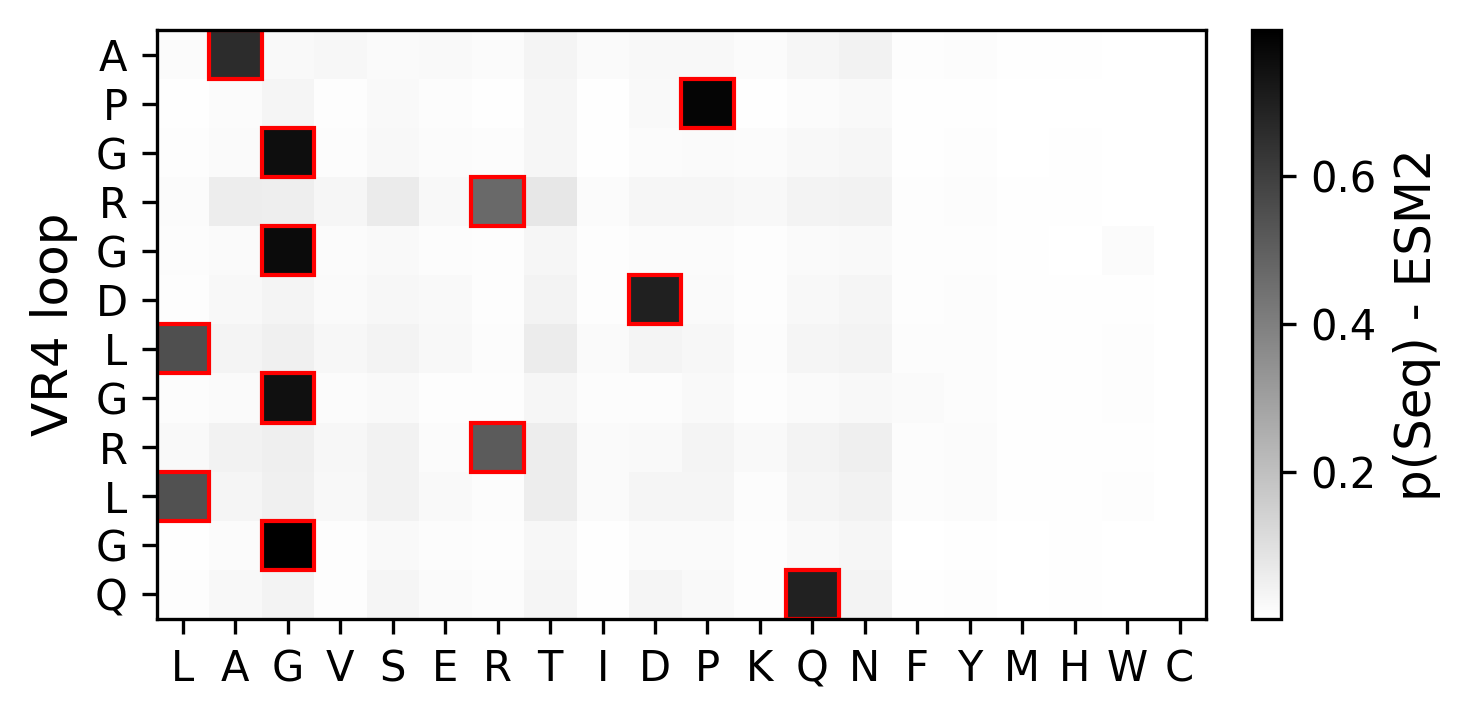

In [9]:
p, motif = list(motifs.items())[0]
f = "cap9_VR4_4um9_try99_1_0001"
start = seq_wt.index(VR)

path_pdb = f'{dir_out_rosetta}/AAV9_{p}/output_design/{f[:-5]}.pdb'
s = get_sequence_from_PDB(path_pdb, "A")
pep = s[233:245]
props = get_ESM2_probs_VP1(motif, pep)

data = props[start:start+len(pep)]
row_indices = [aa2id_np[aa] for aa in pep]

fig, ax = plt.subplots(figsize=(5,2.5), dpi=300)
im = ax.imshow(
    data, cmap="gray_r", aspect="auto",
    interpolation="nearest",
)

# Colorbar
cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cbar.set_label("p(Seq) - ESM2", fontsize=12, )

# X ticks = amino acids
ax.set_xticks(np.arange(props.shape[-1]))
ax.set_xticklabels(list(id2aa.values()), fontsize=10)

# Y ticks = residues in pep
ax.set_yticks(np.arange(len(pep)))
ax.set_yticklabels(list(pep), fontsize=10)

ax.set_ylabel("VR4 loop", fontsize=12)

for spine in ax.spines.values():
    spine.set_linewidth(0.8)

for y, idx in enumerate(row_indices):
    rect = patches.Rectangle(
        (idx - 0.5, y - 0.5), 1, 1,
        linewidth=1, edgecolor='red', facecolor='none'
    )
    ax.add_patch(rect)

plt.tight_layout()
plt.gca().patch.set_alpha(0)
plt.gcf().patch.set_alpha(0)
plt.savefig("../images/heatmap_ESM2.svg", transparent=True)
plt.show()